<a href="https://colab.research.google.com/github/MerveSevim44/deep_learning_works/blob/main/Datathon2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evrem123","key":"587c01479c7223c6a54cba0fa8711333"}'}

In [ ]:
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c datathon-2025



  0% 0.00/4.31M [00:00<?, ?B/s]
100% 4.31M/4.31M [00:00<00:00, 824MB/s]


In [ ]:
!unzip datathon-2025.zip

Archive:  datathon-2025.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import random, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [ ]:
def load_and_preprocess(path):
    df = pd.read_csv(path)
    if "index" in df.columns:
        df = df.drop(columns=["index"])
    df = df.reset_index(drop=True)
    # Tek bir kez event_time dönüşümü
    df["event_time"] = pd.to_datetime(df["event_time"], utc=True, errors="coerce")
    return df

train_df = load_and_preprocess("train.csv")
test_df  = load_and_preprocess("test.csv")

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.select_dtypes(include=np.number).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(train_df)

In [ ]:
train_df['event_time'].dtype

datetime64[ns, UTC]

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(train_df)

In [ ]:
cat_cols,num_cols,cat_but_car

(['event_type'],
 ['event_time', 'session_value'],
 ['product_id', 'category_id', 'user_id', 'user_session'])

In [ ]:
train_df[num_cols].describe().T

,count,mean,min,25%,50%,75%,max,std
event_time,141219,2025-06-11 02:13:19.679221760,2025-06-01 00:00:00,2025-06-06 06:03:00,2025-06-10 14:19:00,2025-06-16 10:26:30,2025-06-21 23:59:00,NaN
session_value,141219.0,75.348539,5.38,23.78,40.95,86.44,2328.66,121.794683


In [ ]:


def num_summary(dataframe, numerical_col, plot=False):
    """
    Generate a clean and beautiful numerical summary.

    Parameters:
    -----------
    dataframe : pd.DataFrame
        The input dataframe
    numerical_col : str
        Name of the numerical column to analyze
    plot : bool, default False
        Whether to generate visualizations
    """

    # Check if column exists
    if numerical_col not in dataframe.columns:
        print(f"❌ Column '{numerical_col}' not found!")
        return

    data = dataframe[numerical_col].dropna()

    print(f"\n📊 Summary for: {numerical_col}")
    print("=" * 50)

    # Basic stats in a clean format
    stats_data = {
        'Count': f"{len(data):,}",
        'Missing': f"{dataframe[numerical_col].isnull().sum():,}",
        'Mean': f"{data.mean():.2f}",
        'Median': f"{data.median():.2f}",
        'Std Dev': f"{data.std():.2f}",
        'Min': f"{data.min():.2f}",
        'Max': f"{data.max():.2f}"
    }

    for key, value in stats_data.items():
        print(f"{key:>8}: {value}")

    # Key quantiles
    print(f"\n📈 Quantiles:")
    quantiles = [0.25, 0.50, 0.75, 0.95]
    for q in quantiles:
        print(f"  {q*100:3.0f}%: {data.quantile(q):8.2f}")

    # Simple outlier check
    Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
    print(f"\n🚨 Outliers: {len(outliers):,} ({len(outliers)/len(data)*100:.1f}%)")

    if plot:
        # Set style
        plt.style.use('default')
        sns.set_palette("husl")

        # Create 2x2 subplot
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f'Analysis of {numerical_col}', fontsize=16, fontweight='bold')

        # 1. Histogram with mean line
        axes[0,0].hist(data, bins=25, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
        axes[0,0].set_title('Distribution')
        axes[0,0].set_xlabel(numerical_col)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # 2. Box plot
        box = axes[0,1].boxplot(data, patch_artist=True)
        box['boxes'][0].set_facecolor('lightgreen')
        axes[0,1].set_title('Box Plot')
        axes[0,1].set_ylabel(numerical_col)
        axes[0,1].grid(True, alpha=0.3)

        # 3. Line plot (sorted values)
        sorted_data = sorted(data)
        axes[1,0].plot(sorted_data, color='purple', linewidth=2)
        axes[1,0].set_title('Sorted Values')
        axes[1,0].set_xlabel('Index')
        axes[1,0].set_ylabel(numerical_col)
        axes[1,0].grid(True, alpha=0.3)

        # 4. Summary stats as text
        axes[1,1].axis('off')
        summary_text = f"""
Key Statistics:

Count: {len(data):,}
Mean: {data.mean():.2f}
Median: {data.median():.2f}
Std Dev: {data.std():.2f}

Min: {data.min():.2f}
Max: {data.max():.2f}
Range: {data.max()-data.min():.2f}

Outliers: {len(outliers):,}
        """

        axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes,
                      fontsize=11, verticalalignment='top', fontfamily='monospace',
                      bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow"))

        plt.tight_layout()
        plt.show()

    print("=" * 50)

# Example usage:
# num_summary(df, 'column_name', plot=True)


📊 Summary for: session_value
   Count: 141,219
 Missing: 0
    Mean: 75.35
  Median: 40.95
 Std Dev: 121.79
     Min: 5.38
     Max: 2328.66

📈 Quantiles:
   25%:    23.78
   50%:    40.95
   75%:    86.44
   95%:   238.01

🚨 Outliers: 12,250 (8.7%)


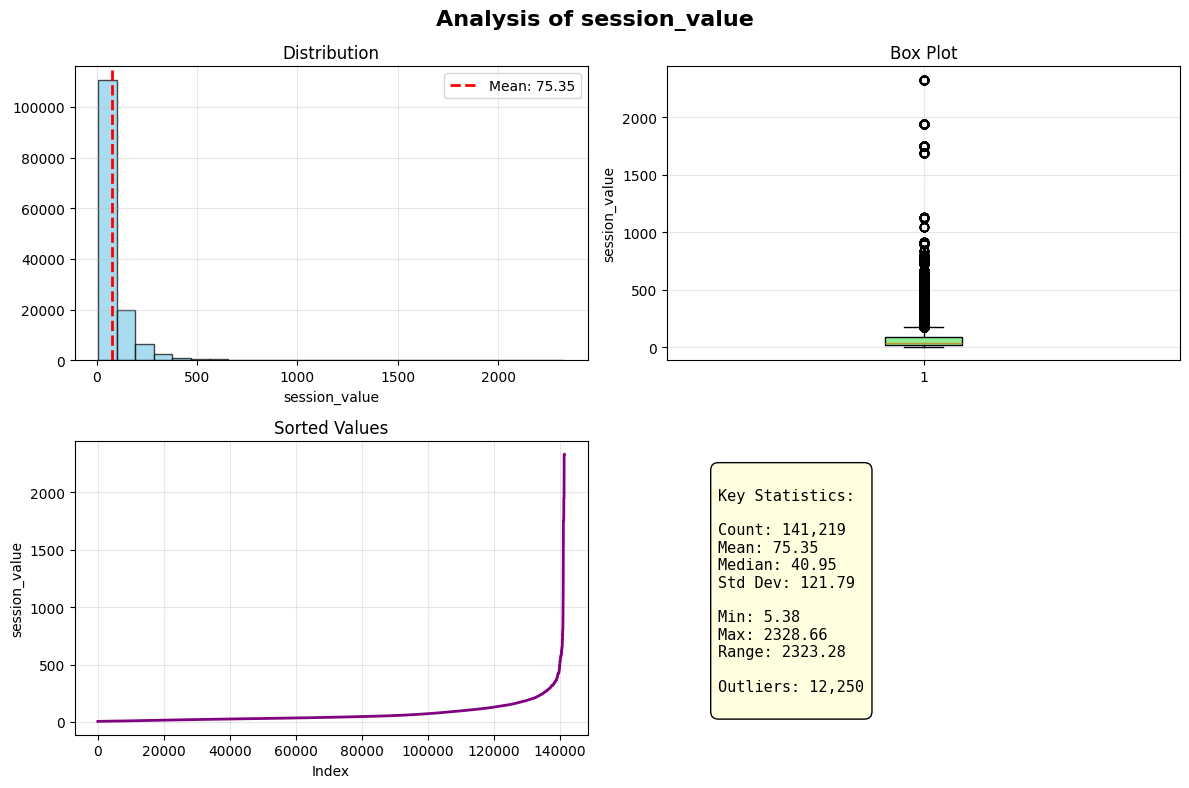

In [ ]:
num_summary(train_df, 'session_value', plot=True)

In [ ]:


def cat_summary(dataframe, col_name, plot=False, top_n=10):
    """
    Generate a beautiful categorical summary with visualizations.

    Parameters:
    -----------
    dataframe : pd.DataFrame
        The input dataframe
    col_name : str
        Name of the categorical column to analyze
    plot : bool, default False
        Whether to generate visualizations
    top_n : int, default 10
        Number of top categories to show in plots
    """

    # Check if column exists
    if col_name not in dataframe.columns:
        print(f"❌ Column '{col_name}' not found!")
        return

    data = dataframe[col_name]

    print(f"\n📊 Categorical Summary for: {col_name}")
    print("=" * 60)

    # Basic info
    total_count = len(data)
    missing_count = data.isnull().sum()
    unique_count = data.nunique()
    valid_count = total_count - missing_count

    print(f"\n📈 Basic Information:")
    print(f"{'Total Records':>15}: {total_count:,}")
    print(f"{'Missing Values':>15}: {missing_count:,} ({missing_count/total_count*100:.1f}%)")
    print(f"{'Valid Records':>15}: {valid_count:,}")
    print(f"{'Unique Categories':>15}: {unique_count:,}")

    if unique_count == 0:
        print("❌ No valid categories to analyze!")
        return

    # Value counts
    value_counts = data.value_counts()
    percentages = (value_counts / valid_count * 100)

    # Create summary table
    print(f"\n📋 Category Distribution:")
    print("-" * 60)
    print(f"{'Category':<25} {'Count':>10} {'Percentage':>12} {'Bar':>10}")
    print("-" * 60)

    # Show top categories with visual bars
    max_count = value_counts.iloc[0] if len(value_counts) > 0 else 1
    for i, (category, count) in enumerate(value_counts.head(15).items()):
        pct = percentages.iloc[i]
        bar_length = int(count / max_count * 20)
        bar = '█' * bar_length

        # Truncate long category names
        cat_display = str(category)[:22] + '...' if len(str(category)) > 25 else str(category)

        print(f"{cat_display:<25} {count:>10,} {pct:>11.1f}% {bar}")

    if len(value_counts) > 15:
        remaining = len(value_counts) - 15
        remaining_count = value_counts.iloc[15:].sum()
        remaining_pct = remaining_count / valid_count * 100
        print(f"{'... ' + str(remaining) + ' more':<25} {remaining_count:>10,} {remaining_pct:>11.1f}%")

    # Statistics
    print(f"\n📊 Distribution Statistics:")
    print(f"{'Most Common':>20}: {value_counts.index[0]} ({percentages.iloc[0]:.1f}%)")
    if len(value_counts) > 1:
        print(f"{'Second Most Common':>20}: {value_counts.index[1]} ({percentages.iloc[1]:.1f}%)")

    # Diversity measures
    diversity_score_str = 'N/A'
    if unique_count > 1:
        # Calculate entropy (diversity measure)
        probs = value_counts / valid_count
        entropy = -np.sum(probs * np.log2(probs + 1e-10))
        max_entropy = np.log2(unique_count)
        diversity_score = entropy / max_entropy
        diversity_score_str = f"{diversity_score:.3f}"

    print(f"{'Diversity Score':>20}: {diversity_score_str} (0=low, 1=high)")

    # Rare categories (< 1%)
    rare_categories = value_counts[percentages < 1.0]
    if len(rare_categories) > 0:
        print(f"{'Rare Categories':>20}: {len(rare_categories)} (<1% each)")

    # Visualizations
    if plot:
        plt.style.use('default')
        sns.set_palette("husl")

        # Limit to top categories for better visualization
        plot_data = value_counts.head(top_n)

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Categorical Analysis: {col_name}', fontsize=16, fontweight='bold')

        # 1. Horizontal Bar Chart (better for long category names)
        y_pos = range(len(plot_data))
        axes[0,0].barh(y_pos, plot_data.values, color='skyblue', alpha=0.8)
        axes[0,0].set_yticks(y_pos)
        axes[0,0].set_yticklabels([str(cat)[:20] + '...' if len(str(cat)) > 23 else str(cat)
                                  for cat in plot_data.index])
        axes[0,0].set_xlabel('Count')
        axes[0,0].set_title(f'Top {min(top_n, len(plot_data))} Categories')
        axes[0,0].grid(True, alpha=0.3, axis='x')

        # Add count labels on bars
        for i, v in enumerate(plot_data.values):
            axes[0,0].text(v + max(plot_data.values) * 0.01, i, f'{v:,}',
                          va='center', fontweight='bold')

        # 2. Pie Chart (for top categories)
        plot_data_pie = plot_data.head(8)  # Limit for readability
        if len(value_counts) > 8:
            others_count = value_counts.iloc[8:].sum()
            plot_data_pie = pd.concat([plot_data_pie, pd.Series([others_count], index=['Others'])])

        colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data_pie)))
        wedges, texts, autotexts = axes[0,1].pie(plot_data_pie.values,
                                                labels=[str(cat)[:15] + '...' if len(str(cat)) > 18 else str(cat)
                                                       for cat in plot_data_pie.index],
                                                autopct='%1.1f%%',
                                                colors=colors,
                                                startangle=90)
        axes[0,1].set_title('Distribution (Top Categories)')

        # 3. Cumulative Percentage
        cumulative_pct = (value_counts / valid_count * 100).cumsum()
        axes[1,0].plot(range(1, min(51, len(cumulative_pct) + 1)),
                      cumulative_pct.head(50),
                      marker='o', linewidth=2, markersize=4, color='green')
        axes[1,0].set_xlabel('Category Rank')
        axes[1,0].set_ylabel('Cumulative Percentage')
        axes[1,0].set_title('Cumulative Distribution')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% line')
        axes[1,0].legend()

        # 4. Summary Statistics Panel
        axes[1,1].axis('off')

        summary_text = f"""
📊 Category Summary:

Total Records: {total_count:,}
Valid Records: {valid_count:,}
Missing: {missing_count:,} ({missing_count/total_count*100:.1f}%)

Unique Categories: {unique_count:,}
Most Common: {value_counts.index[0]}
  → {value_counts.iloc[0]:,} records ({percentages.iloc[0]:.1f}%)

Rare Categories: {len(rare_categories):,} (<1%)
Top 5 cover: {percentages.head(5).sum():.1f}% of data

Diversity Score: {diversity_score_str} (0=low, 1=high)
        """

        axes[1,1].text(0.1, 0.9, summary_text, transform=axes[1,1].transAxes,
                      fontsize=11, verticalalignment='top', fontfamily='monospace',
                      bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))

        plt.tight_layout()
        plt.show()

    print("=" * 60)

# Example usage:
# cat_summary(df, 'category_column', plot=True)
# cat_summary(df, 'status', plot=True, top_n=15)


📊 Categorical Summary for: event_type

📈 Basic Information:
  Total Records: 141,219
 Missing Values: 0 (0.0%)
  Valid Records: 141,219
Unique Categories: 4

📋 Category Distribution:
------------------------------------------------------------
Category                       Count   Percentage        Bar
------------------------------------------------------------
VIEW                          58,829        41.7% ████████████████████
ADD_CART                      42,304        30.0% ██████████████
REMOVE_CART                   25,615        18.1% ████████
BUY                           14,471        10.2% ████

📊 Distribution Statistics:
         Most Common: VIEW (41.7%)
  Second Most Common: ADD_CART (30.0%)
     Diversity Score: 0.915 (0=low, 1=high)


/tmp/ipython-input-2923295565.py:172: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


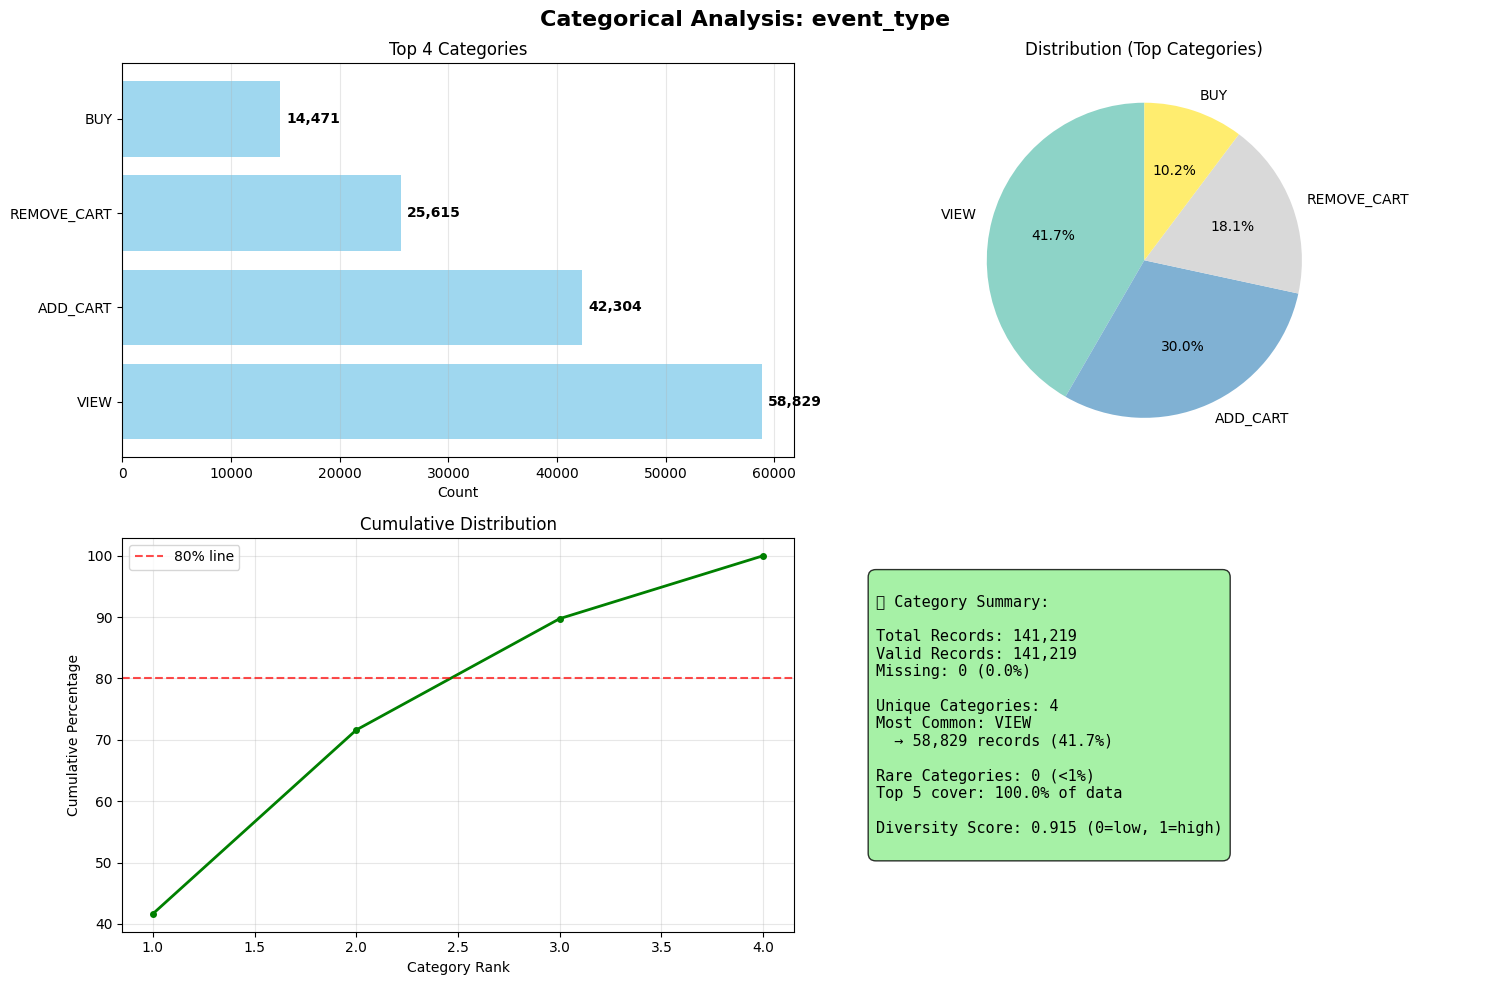

In [ ]:
cat_summary(train_df,'event_type',plot=True)

In [ ]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [ ]:
num_cols

['event_time', 'session_value']

In [ ]:
target_summary_with_num(train_df, 'session_value', 'event_time')

                                 event_time
session_value                              
5.38          2025-06-12 06:04:36.601941760
5.39          2025-06-09 01:46:30.000000000
5.40          2025-06-09 16:07:38.823529472
5.41          2025-06-13 19:04:08.000000000
5.42          2025-06-15 05:02:10.909090816
...                                     ...
1137.33       2025-06-09 13:56:10.000000000
1691.01       2025-06-10 11:01:23.181818112
1749.42       2025-06-15 09:10:42.413793024
1946.93       2025-06-15 11:45:27.741935616
2328.66       2025-06-16 07:53:50.000000000

[12719 rows x 1 columns]





=== VIEW ===
            count       mean        std   min      25%     50%    75%      max
has_VIEW                                                                      
False     26776.0  53.559939  53.617241  5.38  23.9775  38.975  61.24  1946.93
True      43960.0  35.277661  41.964608  5.38  16.5875  27.100  39.59  2328.66

=== ADD_CART ===
                count       mean        std   min    25%    50%    75%  \
has_ADD_CART                                                             
False         44311.0  34.626317  38.630333  5.38  14.35  24.92  37.53   
True          26425.0  54.894992  57.387750  5.38  29.23  41.43  58.08   

                  max  
has_ADD_CART           
False         1051.66  
True          2328.66  

=== REMOVE_CART ===
                   count       mean        std   min    25%    50%      75%  \
has_REMOVE_CART                                                               
False            58066.0  40.274295  39.790678  5.38  19.62  31.07  45.2700   
T

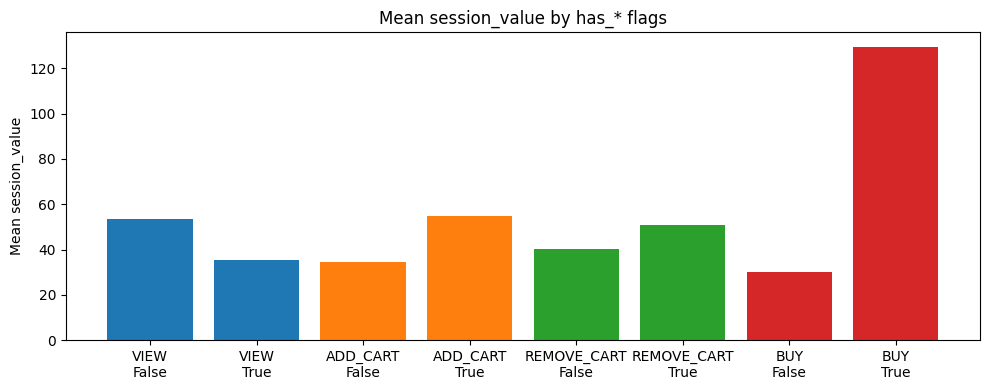

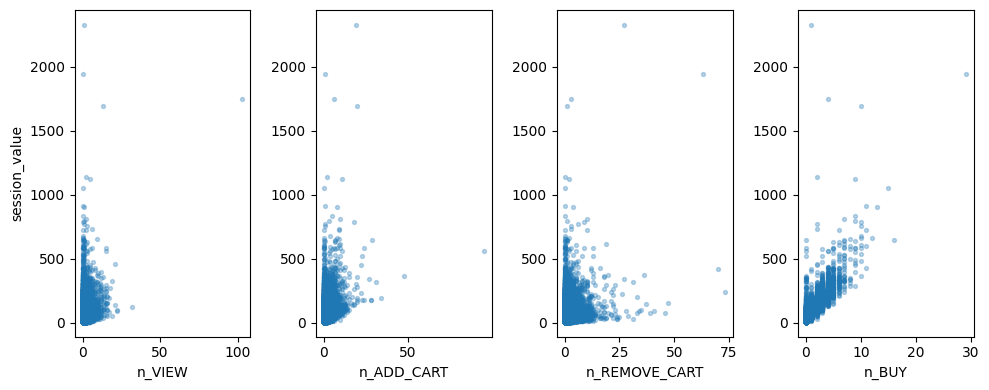

In [ ]:

# --- 1) Oturum seviyesinde özellikleri üret ---
def build_session_features(df):
    d = df.copy()
    d["event_time"] = pd.to_datetime(d["event_time"], utc=True, errors="coerce").dt.tz_localize(None)

    # Hedef (oturum seviyesi)
    y = d.groupby("user_session")["session_value"].first().rename("session_value")

    # Event tiplerine göre sayımlar -> n_VIEW, n_ADD_CART, n_REMOVE_CART, n_BUY ...
    cnt = (d.groupby(["user_session","event_type"])
             .size().unstack(fill_value=0))
    cnt.columns = [f"n_{c}" for c in cnt.columns]

    # Var/yok bayrakları -> has_VIEW, has_ADD_CART, ...
    has_ = (cnt.gt(0)).rename(columns=lambda c: c.replace("n_","has_"))

    # Oturum uzunluğu, benzersiz ürün/kategori, süre
    n_events     = d.groupby("user_session").size().rename("n_events")
    n_products   = d.groupby("user_session")["product_id"].nunique().rename("n_products")
    n_categories = d.groupby("user_session")["category_id"].nunique().rename("n_categories")
    t_agg        = d.groupby("user_session")["event_time"].agg(["min","max"])
    duration_min = ((t_agg["max"] - t_agg["min"]).dt.total_seconds()/60).rename("duration_min")

    # Net sepet ve oranlar (0 bölmeyi önle)
    n_add = cnt.get("n_ADD_CART", pd.Series(0, index=cnt.index))
    n_rm  = cnt.get("n_REMOVE_CART", pd.Series(0, index=cnt.index))
    n_buy = cnt.get("n_BUY", pd.Series(0, index=cnt.index))
    net_cart = (n_add - n_rm).rename("net_cart")

    feats = pd.concat([y, cnt, has_, n_events, n_products, n_categories, duration_min, net_cart], axis=1).fillna(0)

    # Oranlar
    feats["buy_to_add"]  = feats["n_BUY"]      / feats["n_ADD_CART"].replace(0, np.nan)
    feats["add_to_view"] = feats["n_ADD_CART"] / feats["n_VIEW"].replace(0, np.nan)

    return feats

feats = build_session_features(train_df)

# --- 2) Her event tipi için 'var/yok' bazında session_value özetleri ---
for ev in ["VIEW", "ADD_CART", "REMOVE_CART", "BUY"]:
    col = f"has_{ev}"
    if col in feats:
        print(f"\n=== {ev} ===")
        print(feats.groupby(col)["session_value"].describe())

# --- 3) Korelasyon: session_value ile sayımlar/oranlar/diğer öznitelikler ---
corr_cols = [c for c in feats.columns
             if c.startswith("n_") or c in ["net_cart","buy_to_add","add_to_view",
                                            "n_events","n_products","n_categories","duration_min"]]
corr = feats[corr_cols + ["session_value"]].corr()["session_value"].sort_values(ascending=False)
print("\n\nCorrelation with session_value (descending):\n", corr)

# --- 4) İsteğe bağlı: görsel özetler ---
# a) has_* gruplarına göre ortalama session_value bar grafiği
means = {ev: feats.groupby(f"has_{ev}")["session_value"].mean() for ev in ["VIEW","ADD_CART","REMOVE_CART","BUY"] if f"has_{ev}" in feats}
plt.figure(figsize=(10,4))
for i,(ev, s) in enumerate(means.items()):
    plt.bar([f"{ev}\n{idx}" for idx in s.index], s.values, label=ev)
plt.title("Mean session_value by has_* flags")
plt.ylabel("Mean session_value")
plt.tight_layout(); plt.show()

# b) n_ADD_CART, n_REMOVE_CART, n_BUY sayılarıyla ilişki (scatter)
plt.figure(figsize=(10,4))
for i,c in enumerate([c for c in ["n_VIEW","n_ADD_CART","n_REMOVE_CART","n_BUY"] if c in feats]):
    ax = plt.subplot(1,4,i+1)
    ax.scatter(feats[c], feats["session_value"], alpha=0.3, s=8)
    ax.set_xlabel(c);
    if i==0: ax.set_ylabel("session_value")
plt.tight_layout(); plt.show()


In [ ]:
df = train_df.copy()
df["event_time"] = (pd.to_datetime(df["event_time"], utc=True, errors="coerce")
                      .dt.tz_convert("Europe/Istanbul")
                      .dt.tz_localize(None))

# 2) Oturum seviyesi tablo (başlangıç saati)
sess = df.groupby("user_session").agg(
    session_value=("session_value", "first"),
    start_time=("event_time", "min"),
)
sess["start_hour"] = sess["start_time"].dt.hour

# 3) Gün içi dilimler: Gece/Sabah/Öğle/Akşam (istersen değiştirebilirsin)
bins   = [-1, 6, 12, 18, 24]
labels = ["Gece(00-06)", "Sabah(06-12)", "Öğle(12-18)", "Akşam(18-24)"]
sess["day_part"] = pd.cut(sess["start_hour"], bins=bins, labels=labels)

# 4) Özet (count/mean/median) → out tablosu
out = (sess.groupby("day_part")["session_value"]
            .agg(count="count", mean="mean", median="median")
            .round(2))
print(out)

              count   mean  median
day_part                          
Gece(00-06)    8596  40.41   31.17
Sabah(06-12)  18841  42.28   31.82
Öğle(12-18)   23690  47.32   34.36
Akşam(18-24)  19609  36.71   24.99


/tmp/ipython-input-3116788751.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = (sess.groupby("day_part")["session_value"]


In [ ]:
train_df.head(20)

,event_time,event_type,product_id,category_id,user_id,user_session,session_value
0,2025-06-01 00:00:00,ADD_CART,PROD_017825,CAT_00149,USER_019891,SESSION_035068,80.63
1,2025-06-01 00:01:00,REMOVE_CART,PROD_006888,CAT_00094,USER_012699,SESSION_054667,42.66
2,2025-06-01 00:01:00,REMOVE_CART,PROD_030474,CAT_00267,USER_012699,SESSION_054667,42.66
3,2025-06-01 00:01:00,REMOVE_CART,PROD_018192,CAT_00149,USER_012699,SESSION_054667,42.66
4,2025-06-01 00:01:00,REMOVE_CART,PROD_000266,CAT_00150,USER_019891,SESSION_035068,80.63
5,2025-06-01 00:02:00,ADD_CART,PROD_024977,CAT_00011,USER_018791,SESSION_028880,44.63
6,2025-06-01 00:03:00,VIEW,PROD_016259,CAT_00017,USER_053939,SESSION_049012,22.57
7,2025-06-01 00:03:00,VIEW,PROD_002861,CAT_00277,USER_053942,SESSION_135081,47.79
8,2025-06-01 00:04:00,REMOVE_CART,PROD_019917,CAT_00268,USER_012699,SESSION_054667,42.66
9,2025-06-01 00:04:00,REMOVE_CART,PROD_004863,CAT_00436,USER_012699,SESSION_054667,42.66


In [ ]:
train_df['product_id'].nunique()

26470

In [ ]:

def add_row_level_features(df):
    out = df.copy()
    et = pd.to_datetime(out["event_time"], utc=True, errors="coerce") \
            .dt.tz_convert("Europe/Istanbul").dt.tz_localize(None).dt.floor("min")
    out["event_time_local"] = et
    out["hour"] = et.dt.hour
    out["dow"]  = et.dt.dayofweek
    out["is_weekend"] = out["dow"].isin([5,6]).astype(int)
    out["day_part"] = pd.cut(out["hour"],
                             bins=[-1,6,12,18,24],
                             labels=["Gece(00-06)","Sabah(06-12)","Öğle(12-18)","Akşam(18-24)"])

    # --- SIRALAMA & SÜRE ---
    out = out.sort_values(["user_session","event_time_local"], kind="mergesort")
    out["step"] = out.groupby("user_session").cumcount() + 1
    sess_size = out.groupby("user_session")["event_type"].transform("size")
    out["step_pct"] = out["step"] / sess_size

    # süreler
    grp = out.groupby("user_session")["event_time_local"]
    out["time_since_prev_min"]  = grp.diff().dt.total_seconds().div(60).fillna(0)
    out["time_since_start_min"] = (out["event_time_local"] - grp.transform("min")) \
                                    .dt.total_seconds().div(60)

    # --- EVENT SAYIMLARI (yayılmış) ---
    for ev in ["VIEW","ADD_CART","REMOVE_CART","BUY"]:
        out[f"is_{ev}"] = (out["event_type"]==ev).astype(int)
        out[f"sess_n_{ev}"] = out.groupby("user_session")[f"is_{ev}"].transform("sum")
        out[f"cum_{ev}"]    = out.groupby("user_session")[f"is_{ev}"].cumsum()

    out["sess_n_events"] = sess_size
    out["sess_net_cart_total"] = out["sess_n_ADD_CART"] - out["sess_n_REMOVE_CART"]
    out["net_cart_now"] = out["cum_ADD_CART"] - out["cum_REMOVE_CART"]

    # --- KATEGORİ (oturum × kategori) ---
    # Bu oturumda bu kategoride kaç event?
    out["events_in_cat_session"] = out.groupby(["user_session","category_id"])["event_type"] \
                                        .transform("size")
    # Bu oturumda bu kategoriden BUY var mı?
    buy_mask = (out["event_type"]=="BUY").astype(int)
    out["buy_in_cat_session"] = out.groupby(["user_session","category_id"])[buy_mask.name] \
                                     .transform("max").astype(bool)

    # --- POPÜLARİTE / FREKANS ---
    prod_counts = out["product_id"].value_counts()
    cat_counts  = out["category_id"].value_counts()
    out["prod_freq"] = out["product_id"].map(prod_counts).fillna(0).astype(int)
    out["cat_freq"]  = out["category_id"].map(cat_counts).fillna(0).astype(int)

    # Kategorideki benzersiz ürün sayısı (ürün çeşitliliği sinyali)
    cat_prod_count = out.groupby("category_id")["product_id"].transform("nunique")
    out["cat_prod_count"] = cat_prod_count

    # Temizlik: yardımcı bayrak kolonlarını istersen kaldır
    out.drop(columns=[c for c in out.columns if c.startswith("is_")], inplace=True)

    # Sıra korunmuş temiz index
    out = out.reset_index(drop=True)
    return out

# kullanım
feat_df = add_row_level_features(train_df)

In [ ]:
feat_df.tail(10)

,event_time,event_type,product_id,category_id,user_id,user_session,session_value,event_time_local,hour,dow,...,sess_n_BUY,cum_BUY,sess_n_events,sess_net_cart_total,net_cart_now,events_in_cat_session,buy_in_cat_session,prod_freq,cat_freq,cat_prod_count
141209,2025-06-07 13:50:26+00:00,VIEW,PROD_010812,CAT_00010,USER_004153,SESSION_189757,53.16,2025-06-07 16:50:00,16,5,...,0,0,3,1,1,1,True,41,5006,502
141210,2025-06-02 13:22:16+00:00,VIEW,PROD_025754,CAT_00027,USER_060806,SESSION_189759,10.57,2025-06-02 16:22:00,16,0,...,0,0,1,0,0,1,True,2,4041,529
141211,2025-06-08 03:09:48+00:00,REMOVE_CART,PROD_011849,CAT_00027,USER_001555,SESSION_189761,14.35,2025-06-08 06:09:00,6,6,...,0,0,2,-2,-1,1,True,24,4041,529
141212,2025-06-08 03:09:39+00:00,REMOVE_CART,PROD_001391,CAT_00453,USER_001555,SESSION_189761,14.35,2025-06-08 06:09:00,6,6,...,0,0,2,-2,-2,1,True,59,198,5
141213,2025-06-21 13:09:31+00:00,VIEW,PROD_008156,CAT_00454,USER_100670,SESSION_189762,24.36,2025-06-21 16:09:00,16,5,...,0,0,1,0,0,1,True,11,62,4
141214,2025-06-07 19:22:21+00:00,VIEW,PROD_005189,CAT_00280,USER_032219,SESSION_189763,56.69,2025-06-07 22:22:00,22,5,...,0,0,1,0,0,1,True,6,2812,951
141215,2025-06-06 09:23:11+00:00,VIEW,PROD_027411,CAT_00415,USER_033700,SESSION_189764,25.06,2025-06-06 12:23:00,12,4,...,0,0,1,0,0,1,True,4,290,25
141216,2025-06-13 12:12:17+00:00,BUY,PROD_025702,CAT_00027,USER_088534,SESSION_189765,107.62,2025-06-13 15:12:00,15,4,...,1,1,1,0,0,1,True,33,4041,529
141217,2025-06-17 22:42:31+00:00,REMOVE_CART,PROD_024454,CAT_00308,USER_008320,SESSION_189769,16.36,2025-06-18 01:42:00,1,2,...,0,0,1,-1,-1,1,True,26,2914,212
141218,2025-06-13 15:15:18+00:00,VIEW,PROD_031908,CAT_00046,USER_001524,SESSION_189770,12.87,2025-06-13 18:15:00,18,4,...,0,0,1,0,0,1,True,23,5016,633


In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(feat_df)

In [ ]:
cat_cols, num_cols, cat_but_car

(['event_type', 'dow', 'day_part', 'buy_in_cat_session'],
 ['event_time',
  'session_value',
  'event_time_local',
  'hour',
  'step',
  'step_pct',
  'time_since_prev_min',
  'time_since_start_min',
  'sess_n_VIEW',
  'cum_VIEW',
  'sess_n_ADD_CART',
  'cum_ADD_CART',
  'sess_n_REMOVE_CART',
  'cum_REMOVE_CART',
  'sess_n_BUY',
  'cum_BUY',
  'sess_n_events',
  'sess_net_cart_total',
  'net_cart_now',
  'events_in_cat_session',
  'prod_freq',
  'cat_freq',
  'cat_prod_count'],
 ['product_id', 'category_id', 'user_id', 'user_session'])

In [ ]:
from sklearn.preprocessing import StandardScaler
df = feat_df.sort_values(["user_session","event_time_local"], kind="mergesort").copy()

# id → index
for col in ["event_type","product_id","category_id"]:
    if col + "_idx" not in df:
        df[col + "_idx"] = pd.Categorical(df[col]).codes + 1

V_EVT  = int(df["event_type_idx"].max()) + 2
V_PROD = int(df["product_id_idx"].max()) + 2
V_CAT  = int(df["category_id_idx"].max()) + 2

# Sıra içi sayısal kanallar (2 adet)
SEQ_NUM_COLS = ["time_since_prev_min", "net_cart_now", "time_since_start_min"]

# Statik (oturum-özet) sayısal özellikler
STAT_COLS = [
    "sess_n_VIEW","sess_n_ADD_CART","sess_n_REMOVE_CART","sess_n_BUY",
    "sess_n_events","sess_net_cart_total",
    "hour","prod_freq","cat_freq","cat_prod_count"
]

# Normalizasyon (sayısal özellikler için)
scaler = StandardScaler()
feat_df[STAT_COLS] = scaler.fit_transform(feat_df[STAT_COLS])

In [ ]:
from tensorflow.keras import layers as L, Model

def build_inputs(d, max_len=120):
    X_evt, X_prod, X_cat, X_num, X_stat, y, starts = [],[],[],[],[],[],[]
    for sid, g in d.groupby("user_session", sort=False):
        # int diziler
        a_evt  = g["event_type_idx"].to_numpy(np.int32)
        a_prod = g["product_id_idx"].to_numpy(np.int32)
        a_cat  = g["category_id_idx"].to_numpy(np.int32)
        # numeric diziler (log1p gap)
        num = g[SEQ_NUM_COLS].copy()
        num["time_since_prev_min"] = np.log1p(num["time_since_prev_min"])
        num = num.fillna(0.0).to_numpy(np.float32)   # (T, len(SEQ_NUM_COLS))  <-- 2 kanal

        # pad/trim (SON max_len)
        def pad_int(a):
            if len(a)>max_len: a=a[-max_len:]
            if len(a)<max_len: a=np.pad(a,(max_len-len(a),0),constant_values=0)
            return a
        def pad_num(a):
            T=a.shape[0]
            if T>max_len: a=a[-max_len:,:]
            if T<max_len: a=np.pad(a,((max_len-T,0),(0,0)),constant_values=0.0)
            return a

        X_evt.append(pad_int(a_evt))
        X_prod.append(pad_int(a_prod))
        X_cat.append(pad_int(a_cat))
        X_num.append(pad_num(num))
        X_stat.append(g.iloc[0][STAT_COLS].astype("float32").to_numpy())
        y.append(g["session_value"].iloc[0])
        starts.append(g["event_time_local"].iloc[0])

    X = {
        "evt":  np.stack(X_evt),
        "prod": np.stack(X_prod),
        "cat":  np.stack(X_cat),
        "num":  np.stack(X_num),
        "stat": np.stack(X_stat).astype("float32"),
    }
    y = np.log1p(np.asarray(y, np.float32))
    meta = pd.DataFrame({"start": starts})
    return X, y, meta

In [ ]:
MAX_LEN = 120

# Add index columns to feat_df
for col in ["event_type","product_id","category_id"]:
    if col + "_idx" not in feat_df.columns:
        feat_df[col + "_idx"] = pd.Categorical(feat_df[col]).codes + 1

V_EVT  = int(feat_df["event_type_idx"].max()) + 2
V_PROD = int(feat_df["product_id_idx"].max()) + 2
V_CAT  = int(feat_df["category_id_idx"].max()) + 2


X_all, y_all, meta = build_inputs(feat_df, max_len=MAX_LEN)


# Zaman bazlı split (son %20 valid)
cut = meta["start"].quantile(0.7)
tr = meta["start"] < cut
vl = ~tr
Xtr = {k:v[tr.values] for k,v in X_all.items()}
Xvl = {k:v[vl.values] for k,v in X_all.items()}
y_tr, y_vl = y_all[tr.values], y_all[vl.values]

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Masking, LSTM, GRU, Dense, Dropout, BatchNormalization, Activation, Bidirectional, Embedding, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax

# input_shape = (T, F)  # Zaman boyu T, özellik boyu F (embedding kullanmıyorsan)
def build_model(hp, input_shapes, vocab_sizes):
    inp_evt = L.Input(shape=input_shapes['evt'], name='evt')
    inp_prod = L.Input(shape=input_shapes['prod'], name='prod')
    inp_cat = L.Input(shape=input_shapes['cat'], name='cat')
    inp_num = L.Input(shape=input_shapes['num'], name='num')
    inp_stat = L.Input(shape=input_shapes['stat'], name='stat')

    emb_dim = hp.Int('embedding_dim', min_value=16, max_value=64, step=16)
    emb_evt  = L.Embedding(vocab_sizes['evt'], emb_dim, mask_zero=True)(inp_evt)
    emb_prod = L.Embedding(vocab_sizes['prod'], emb_dim, mask_zero=True)(inp_prod)
    emb_cat  = L.Embedding(vocab_sizes['cat'], emb_dim, mask_zero=True)(inp_cat)

    concat_seq = L.concatenate([emb_evt, emb_prod, emb_cat, inp_num])
    masked_seq = L.Masking(mask_value=0.0)(concat_seq)

    n_layers = hp.Int('num_layers', 1, 3)
    rnn_type = hp.Choice('rnn_type', ['lstm','gru'])

    x = masked_seq
    for i in range(n_layers):
        units = hp.Int(f'units_{i}', 64, 256, step=64)
        dr    = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        RNN = L.LSTM if rnn_type=='lstm' else L.GRU
        x = RNN(units, return_sequences=(i<n_layers-1), dropout=dr)(x)

    concat_all = L.concatenate([x, inp_stat])

    # Dense katmanlar
    d_units = hp.Int('dense_units', 64, 256, step=64)
    y = L.Dense(d_units, activation='relu', kernel_regularizer=l2(1e-5))(concat_all)
    y = L.Dropout(0.3)(y)

    output = L.Dense(1)(y)
    model = Model(inputs=[inp_evt, inp_prod, inp_cat, inp_num, inp_stat], outputs=output)

    opt = Adam(learning_rate=hp.Float('lr', 1e-4, 1e-3, sampling='log'))
    model.compile(optimizer=opt,
                  loss='mse',
                  metrics=[tf.keras.metrics.MeanSquaredError(),
                           tf.keras.metrics.MeanAbsoluteError()])
    return model

In [ ]:
import keras_tuner as kt

# Determine the input shape based on your data
# Assuming X_all['num'] is the input data for the model
input_shapes = {k: v.shape[1:] for k, v in X_all.items()}
vocab_sizes = {'evt': V_EVT, 'prod': V_PROD, 'cat': V_CAT}

tuner = kt.Hyperband(
    lambda hp: build_model(hp, input_shapes, vocab_sizes),
    objective="val_loss",
    max_epochs=30,
    factor=3,
    directory="kt_dir",
    project_name="rnn_tune"
)

stop_early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

tuner.search(Xtr, y_tr,
             validation_data=(Xvl, y_vl),
             epochs=30,
             batch_size=128,
             callbacks=[stop_early])



Trial 90 Complete [00h 02m 06s]
val_loss: 0.2399643510580063

Best val_loss So Far: 0.23886020481586456
Total elapsed time: 01h 53m 53s


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hp, input_shapes, vocab_sizes)

history = model.fit(Xtr, y_tr,
                    validation_data=(Xvl, y_vl),
                    epochs=30,
                    batch_size=128,
                    callbacks=[stop_early])

Epoch 1/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 2.2994 - mean_absolute_error: 1.0663 - mean_squared_error: 2.2976 - val_loss: 0.3441 - val_mean_absolute_error: 0.4593 - val_mean_squared_error: 0.3423
Epoch 2/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 0.3902 - mean_absolute_error: 0.4997 - mean_squared_error: 0.3884 - val_loss: 0.3000 - val_mean_absolute_error: 0.4366 - val_mean_squared_error: 0.2982
Epoch 3/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 0.3420 - mean_absolute_error: 0.4671 - mean_squared_error: 0.3402 - val_loss: 0.2591 - val_mean_absolute_error: 0.3962 - val_mean_squared_error: 0.2573
Epoch 4/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.3096 - mean_absolute_error: 0.4436 - mean_squared_error: 0.3078 - val_loss: 0.2469 - val_mean_absolute_error: 0.3910 - val_mean_squared_error: 0.2451
Epoch 5/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.3005 - mean_absolute_error: 0.4373 - mean_squared_error: 0.2987 - val_loss: 0.24

In [ ]:
y_pred_val = np.expm1(model.predict(Xvl))   # 👈 log dönüşümünün tersi
y_true_val = np.expm1(y_vl)

664/664 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# y_true_val and y_pred_val log'dan çıkarılmalı
y_pred_val_log = model.predict(Xvl)
y_pred_val = np.expm1(y_pred_val_log).reshape(-1)
y_true_val = np.expm1(y_vl)

rmse = np.sqrt(mean_squared_error(y_true_val, y_pred_val))
print("Validation RMSE (orijinal scale):", rmse)

664/664 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Validation RMSE (orijinal scale): 0.5078563084412507


In [ ]:
train_loss = model.evaluate(Xtr, y_tr, verbose=0)
val_loss = model.evaluate(Xvl, y_vl, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}",)

Train Loss: 0.22163547575473785 Validation Loss: 0.2421911656856537


In [ ]:
#Train Loss: 0.23849715292453766 Validation Loss: 0.24547035992145538
#Train Loss: 0.23938587307929993 Validation Loss: 0.24545975029468536
#Train Loss: 0.014061146415770054 Validation Loss: 0.015930671244859695
#Train Loss: 0.015477446839213371 Validation Loss: 0.016343673691153526
#Train Loss: 0.22163547575473785 Validation Loss: 0.2421911656856537

In [ ]:
model.save("new_rnn_final.keras")

In [ ]:
# ============================================================
# 6) TEST PIPELINE & PREDICTION (SCALER TERS DÖNÜŞÜMLÜ)
# ============================================================

# 1) Feature engineering
test_feat = add_row_level_features(test_df)

# 2) Kronolojik sıralama
test_feat = test_feat.sort_values(["user_session", "event_time_local"], kind="mergesort")

# 3) Vocab mapping (train vocab'a göre)
evt_vocab = pd.Categorical(feat_df["event_type"]).categories.tolist()
event2idx = {e: i+1 for i, e in enumerate(evt_vocab)}   # 0 = pad
test_feat["event_type_idx"] = test_feat["event_type"].map(event2idx).fillna(0).astype("int32")

prod_vocab = pd.Categorical(feat_df["product_id"]).categories.tolist()
product2idx = {e: i+1 for i, e in enumerate(prod_vocab)}
test_feat["product_id_idx"] = test_feat["product_id"].map(product2idx).fillna(0).astype("int32")

cat_vocab = pd.Categorical(feat_df["category_id"]).categories.tolist()
category2idx = {e: i+1 for i, e in enumerate(cat_vocab)}
test_feat["category_id_idx"] = test_feat["category_id"].map(category2idx).fillna(0).astype("int32")

# 4) Sayısal kolonları aynı scaler ile normalize et
test_feat[STAT_COLS] = scaler.transform(test_feat[STAT_COLS])

# 5) Sequence hazırlama
def build_sequences_for_submit(d, max_len=120):
    X_evt, X_prod, X_cat, X_num, X_stat, sessions = [],[],[],[],[],[]
    for sid, g in d.groupby("user_session", sort=False):
        # integer diziler
        a_evt  = g["event_type_idx"].to_numpy(np.int32)
        a_prod = g["product_id_idx"].to_numpy(np.int32)
        a_cat  = g["category_id_idx"].to_numpy(np.int32)

        # numeric diziler
        num = g[SEQ_NUM_COLS].copy()
        num["time_since_prev_min"] = np.log1p(num["time_since_prev_min"])
        num = num.fillna(0.0).to_numpy(np.float32)

        # pad/trim
        def pad_int(a):
            if len(a) > max_len: a = a[-max_len:]
            if len(a) < max_len: a = np.pad(a, (max_len-len(a), 0), constant_values=0)
            return a
        def pad_num(a):
            T = a.shape[0]
            if T > max_len: a = a[-max_len:,:]
            if T < max_len: a = np.pad(a, ((max_len-T,0),(0,0)), constant_values=0.0)
            return a

        X_evt.append(pad_int(a_evt))
        X_prod.append(pad_int(a_prod))
        X_cat.append(pad_int(a_cat))
        X_num.append(pad_num(num))
        X_stat.append(g.iloc[0][STAT_COLS].astype("float32").to_numpy())
        sessions.append(sid)

    X = {
        "evt":  np.stack(X_evt),
        "prod": np.stack(X_prod),
        "cat":  np.stack(X_cat),
        "num":  np.stack(X_num),
        "stat": np.stack(X_stat).astype("float32"),
    }
    return X, sessions

X_test, sessions_test = build_sequences_for_submit(test_feat, max_len=MAX_LEN)

# 6) Tahmin al
y_test_log = model.predict(X_test, verbose=0).reshape(-1)

# 🔹 Scaler ile normalize edilmişse ters dönüşüm uygula
y_test = np.expm1(y_test_log)

# Negatif değerleri sıfırla
y_test = np.clip(y_test, 0, None)

# 7) Submission formatına göre hazırla
pred_s = pd.Series(y_test, index=sessions_test, name="session_value")

sample = pd.read_csv("sample_submission.csv")
sub = sample[["user_session"]].copy()

# Eksik session'larda minimum tahmin değeri ile doldur
min_val = y_test.min() if len(y_test) > 0 else 0.0
sub["session_value"] = sub["user_session"].map(pred_s).fillna(min_val).astype(float)

sub.to_csv("submission.csv", index=False)
print("submission.csv hazır →", sub.shape)
print(sub.head())

submission.csv hazır → (30789, 2)
     user_session  session_value
0  SESSION_164059     187.006027
1  SESSION_109583      46.565319
2  SESSION_171382      33.761040
3  SESSION_137110      38.228565
4  SESSION_146503     199.074417


In [ ]:
sub = pd.read_csv("submission.csv")
sample = pd.read_csv("sample_submission.csv")
assert sub.shape == sample.shape
assert (sub.columns == sample.columns).all()


In [ ]:
sub = pd.read_csv("submission.csv")
print(sub["session_value"].describe())


count    30789.000000
mean        40.852523
std         62.058755
min          9.373356
25%         21.117989
50%         24.995728
75%         37.516483
max       4117.703613
Name: session_value, dtype: float64


In [ ]:
print(train_df["session_value"].describe())


count    141219.000000
mean         75.348539
std         121.794683
min           5.380000
25%          23.780000
50%          40.950000
75%          86.440000
max        2328.660000
Name: session_value, dtype: float64


In [ ]:
!kaggle competitions submit -c datathon-2025 -f submission.csv -m "my message"



100% 0.98M/0.98M [00:00<00:00, 1.47MB/s]
Successfully submitted to Datathon 2025

In [ ]:
!kaggle competitions submissions -c datathon-2025


fileName        date                        description                              status                     publicScore    privateScore   
--------------  --------------------------  ---------------------------------------  -------------------------  -------------  -------------  
submission.csv  2025-09-02 15:11:02.437000  my message                               SubmissionStatus.PENDING                                 
submission.csv  2025-08-30 19:59:42.307000  my message                               SubmissionStatus.COMPLETE  5481.96374788  4155.68999967  
submission.csv  2025-08-30 19:51:38.123000  RNN model submission after fixing error  SubmissionStatus.COMPLETE  5481.96374788  4155.68999967  
submission.csv  2025-08-30 19:44:11.287000  RNN model submission after fixing error  SubmissionStatus.COMPLETE  5481.96374788  4155.68999967  
submission.csv  2025-08-30 19:44:06.637000  first submit from Colab                  SubmissionStatus.COMPLETE  5481.96374788  4155.68999967  

In [ ]:
!kaggle competitions submissions -c datathon-2025

fileName        date                        description                              status                     publicScore    privateScore   
--------------  --------------------------  ---------------------------------------  -------------------------  -------------  -------------  
submission.csv  2025-09-02 15:11:02.437000  my message                               SubmissionStatus.PENDING                                 
submission.csv  2025-08-30 19:59:42.307000  my message                               SubmissionStatus.COMPLETE  5481.96374788  4155.68999967  
submission.csv  2025-08-30 19:51:38.123000  RNN model submission after fixing error  SubmissionStatus.COMPLETE  5481.96374788  4155.68999967  
submission.csv  2025-08-30 19:44:11.287000  RNN model submission after fixing error  SubmissionStatus.COMPLETE  5481.96374788  4155.68999967  
submission.csv  2025-08-30 19:44:06.637000  first submit from Colab                  SubmissionStatus.COMPLETE  5481.96374788  4155.68999967  

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00
